In [1]:
# !pip install tavily-python 
!pip install -U tavily-python langchain_community --quiet
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = "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"

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [4]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"

In [5]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)

llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool,human_assistance]
# tool.invoke("What's a 'node' in LangGraph?")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


In [7]:
graph = graph_builder.compile(checkpointer=memory)

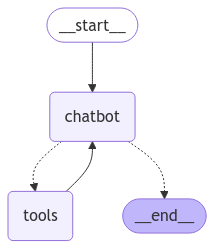

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [10]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (chatcmpl-tool-81ae0e7e123746b59b36f083cf563efc)
 Call ID: chatcmpl-tool-81ae0e7e123746b59b36f083cf563efc
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://colab.research.google.com/github/langchain-ai/langgraph/blob/main/docs/docs/tutorials/introduction.ipynb", "content": "To summarize: 1. LangGraph's original release date: January 17, 2024 2. LangGraph Cloud announcement: June 27, 2024 It's worth noting that LangGraph had been in development and use for some time before the LangGraph Cloud announcement, but the official initial release of LangGraph i

In [11]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

{
    "type": "function",
    "function": {
        "name": "tavily_search_results_json",
        "parameters": {
            "query": "LangGraph release date"
        }
    }
}


In [12]:
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{}

In [13]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe1628-c5b5-6693-8004-8b254f9cd073'}}

In [14]:
snapshot = graph.get_state(config)
{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)'}